In [247]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
import math
import utils
from collections import deque
import random
import seaborn as sns
import utils_adv
from sklearn import preprocessing
from keras.layers import Dense, Dropout, LSTM, GRU, BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
import time

sns.set_theme()
sns.set_style("whitegrid", {'grid.linestyle': '--'})
seq_col_brew = sns.color_palette("flag_r", 4)
sns.set_palette(seq_col_brew)
plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams["axes.titlesize"] = 15
plt.rcParams['savefig.dpi'] = 1200

tf.keras.utils.set_random_seed(2) # relu

#settings
%reload_ext autoreload
%autoreload 3
%config InteractiveShell.ast_node_interactivity = 'all'
%config InlineBackend.figure_format = 'retina'

In [250]:
# load back history data
SEQ_LEN = 60  # how long of a preceeding sequence to collect for RNN
ASSET_TO_PREDICT = 'rx1'                  #--- VAR CHANGE
model_name = '12.24.0029-rx1-60-1'        #--- VAR CHANGE
model_load = keras.models.load_model(f'models/{model_name}.hdf5')
history_load = np.load(f'history/{model_name}.npy',allow_pickle='TRUE').item()

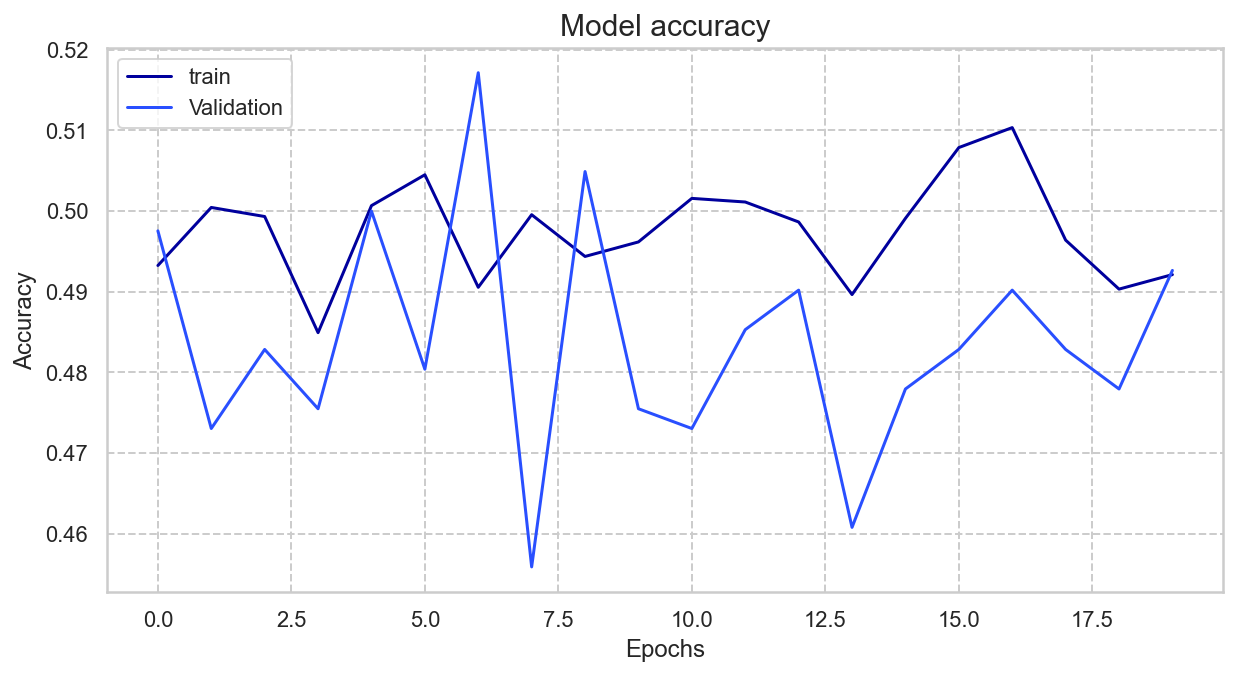

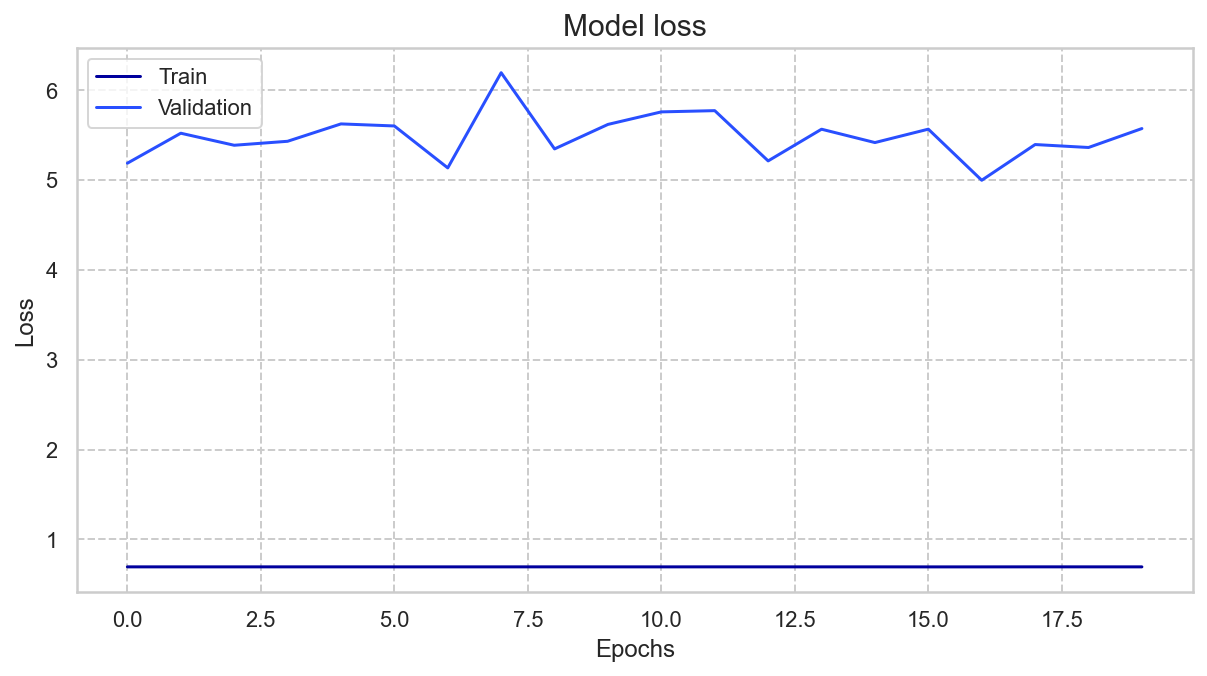

In [251]:
fig1, axs1, fig2, axs2 = utils_adv.plot_history_data(history_load)

In [261]:
# CREDIT DATA
credit_df = pd.DataFrame() # begin empty
rx1, ty1, ik1, oe1, du1 = utils.credit_data_reader()
credit_df['rx1'] = rx1['RX1 Comdty']
# credit_df['du1'] = du1['DU1 Comdty']

# CRYPTO DATA
ratios = ["BTC-USD", "LTC-USD", "BCH-USD", "ETH-USD"]
crypto_df = utils_adv.crypto_data_reader(ratios)

# set dataset                              
dataset_df = credit_df                      # --VAR CHANGE 

val_df = utils_adv.split(dataset_df)[1]
df_rpp = utils_adv.get_rpp(val_df, SEQ_LEN+1, ASSET_TO_PREDICT, model_load)

1/1 [==============================] - 1s 1s/step
[1.2806528e-07 9.9999988e-01]
1/1 [==============================] - 0s 28ms/step
[1.1519078e-07 9.9999988e-01]
1/1 [==============================] - 0s 24ms/step
[5.9486342e-06 9.9999404e-01]
1/1 [==============================] - 0s 24ms/step
[3.0261488e-04 9.9969745e-01]
1/1 [==============================] - 0s 24ms/step
[3.3022955e-04 9.9966979e-01]
1/1 [==============================] - 0s 23ms/step
[9.384724e-06 9.999906e-01]
1/1 [==============================] - 0s 24ms/step
[1.6771206e-04 9.9983227e-01]
1/1 [==============================] - 0s 24ms/step
[2.2887671e-04 9.9977118e-01]
1/1 [==============================] - 0s 25ms/step
[2.2742599e-04 9.9977261e-01]
1/1 [==============================] - 0s 24ms/step
[0.0039347 0.9960653]
1/1 [==============================] - 0s 23ms/step
[1.8953066e-04 9.9981052e-01]
1/1 [==============================] - 0s 23ms/step
[0.00208575 0.99791425]
1/1 [=============================

In [262]:
df_rpp

,r,pred[0],pred[1]
0,0.001709,1.280653e-07,1.000000
1,-0.000294,1.151908e-07,1.000000
2,0.002649,5.948634e-06,0.999994
3,-0.001233,3.026149e-04,0.999697
4,-0.002939,3.302296e-04,0.999670
...,...,...,...
463,-0.008162,3.502789e-04,0.999650
464,-0.002939,2.780076e-05,0.999972
465,-0.004274,2.127087e-06,0.999998
466,0.007697,4.871582e-07,1.000000


Mean:  0.50541973
TP: 209
FP: 259
TN: 0
FN: 0


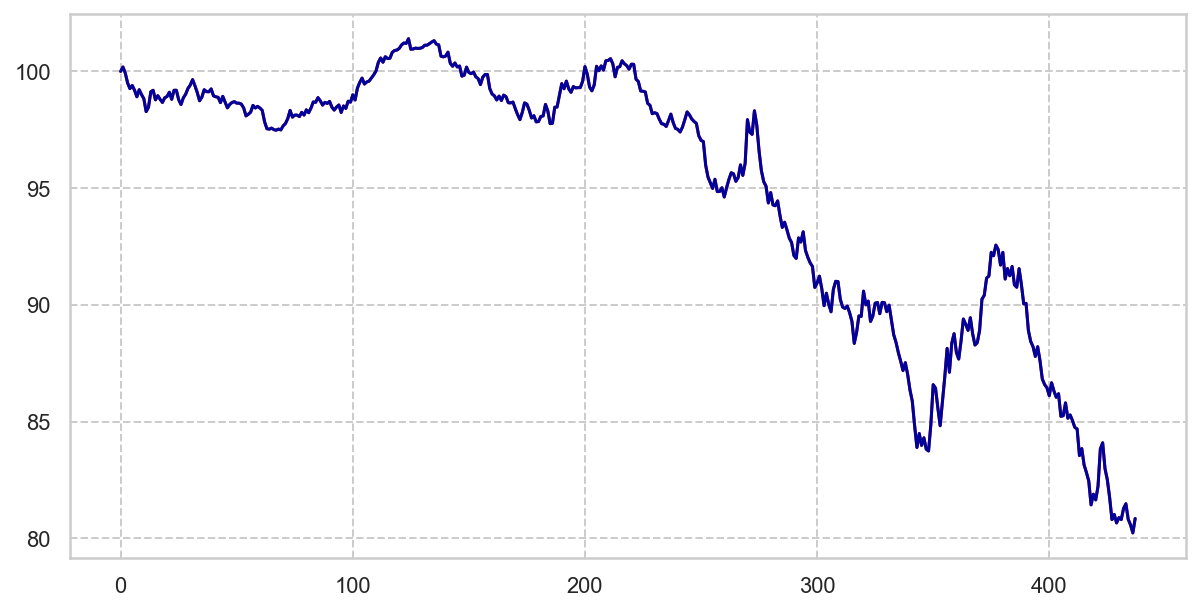

In [246]:
n = 30                       #--- VAR CHANGE
first_n_predictions = df_rpp.loc[0:n, 'pred[0]']
mean = np.mean(first_n_predictions)
print('Mean: ', mean)

treshhold = mean # 0 = always short, 1 = always long. mean ~ 50/50 short/long
copy_df = df_rpp[n:].reset_index(drop=True)
portfolio_value_trading = utils_adv.get_portfolio_value_trading(copy_df, treshhold)
portfolio_value_hold = utils_adv.get_portfolio_value_hold(copy_df)

fig, axs = plt.subplots(1,1, figsize=(10,5))
fig = plt.plot(portfolio_value_trading, color='firebrick', linestyle='-')
fig = plt.plot(portfolio_value_hold)

tp, fp, tn, fn = utils_adv.get_statistics_trading(df_rpp, treshhold)
print(f'TP: {tp}')
print(f'FP: {fp}')
print(f'TN: {tn}')
print(f'FN: {fn}')

# precision = tp / (tp + fp) #of the positive predictions, how many are correct?
# recall = tp / (tp + fn) #how many of the positives did we recall?
# print("Precision: {:5.2f}%".format(100 * precision))
# print("Recall: {:5.2f}%".format(100 * recall))

In [ ]:
correlation = np.corrcoef(portfolio_value_trading, portfolio_value_hold)[1][0]
print("Correlation: {:5.2f}%".format(100 * correlation))

Correlation: 44.42%


In [ ]:
returns_hold = utils_adv.get_daily_returns(portfolio_value_hold)
sharpe_hold = utils_adv.sharpe_ratio(returns_hold, 1440*365, 0.02)
sortino_hold = utils_adv.sortino_ratio(returns_hold, 1440*365, 0.02)
print("Sharpe-ratio, hold: {:5.2f}".format(sharpe_hold))
print("Sortino-ratio, hold: {:5.2f}".format(sortino_hold))
gross_return_hold = utils_adv.get_gross_return(portfolio_value_hold)
print("Gross return, hold: {:5.2f}%".format(100 * gross_return_hold))
print('')

returns_trading = utils_adv.get_daily_returns(portfolio_value_trading)
sharpe_trading = utils_adv.sharpe_ratio(returns_trading, 1440*365, 0.02)
sortino_trading = utils_adv.sortino_ratio(returns_trading, 1440*365, 0.02)
print("Sharpe-ratio, trading: {:5.2f}".format(sharpe_trading))
print("Sortino-ratio, trading: {:5.2f}".format(sortino_trading))
gross_return_trading = utils_adv.get_gross_return(portfolio_value_trading)
print("Gross return, trading: {:5.2f}%".format(100 * gross_return_trading))

Sharpe-ratio, hold:  5.31
Sortino-ratio, hold:  5.53
Gross return, hold:  5.44%

Sharpe-ratio, trading: 11.49
Sortino-ratio, trading: 11.95
Gross return, trading: 12.50%


0.1250176374915469